<a href="https://colab.research.google.com/github/sibyjackgrove/SolarPV-DER-simulation-utility/blob/master/examples/PV-DER_usage_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and usage

## Installation from repository
Users can download the `SolarPV-DER-simulation-utility` repository and install with `pip`. Note that if the installation is done in a Google Colab environment, the kernel need to be restarted before importing the (otherwise you will get a module import error).

In [1]:
import os
try:
    import pvder
except ImportError:
    !git clone https://github.com/sibyjackgrove/SolarPV-DER-simulation-utility.git
        
    if os.path.exists(os.path.join(os.getcwd(), 'SolarPV-DER-simulation-utility')):
        %cd SolarPV-DER-simulation-utility
        !pip install -e .
        %cd ..

## Basic usage

### Import classes
Import classes neccessary to define instances of the PV-DER model, events, simulation, and results.

In [2]:
#Import PV-DER modules
from pvder.DER_components_three_phase  import SolarPV_DER_ThreePhase
from pvder.grid_components import Grid, BaseValues
from pvder.dynamic_simulation import DynamicSimulation
from pvder.simulation_events import SimulationEvents
from pvder.simulation_utilities import SimulationUtilities,SimulationResults
from pvder import utility_functions

#Import Python modules
import logging
import numpy as np
import scipy as sci
import matplotlib as matplotlib
import math
import cmath
print('Scipy version:',sci.__version__)
print('Numpy version:',np.__version__)
print('Matplotlib version:',matplotlib.__version__)
#To show interactive plot in the notebook cell
%matplotlib inline    

Scipy version: 1.2.1
Numpy version: 1.16.2
Matplotlib version: 3.1.2


### Load time series voltages from CSV file

In [3]:
import pandas
voltages = pandas.read_csv('voltage_time_series_for_loop_mode_testing.csv') #Read CSV file using Pandas and convert to numpyt array 
print(voltages.head()) #Show first few rows
Vat_t = np.array(voltages[['VA','Angle A']])
Vbt_t = np.array(voltages[['VB','Angle B']])
Vct_t = np.array(voltages[['VC','Angle C']])
Va = cmath.rect(Vat_t[0][0], math.radians(Vat_t[0][1]))
Vb = cmath.rect(Vbt_t[0][0], math.radians(Vbt_t[0][1]))
Vc = cmath.rect(Vct_t[0][0], math.radians(Vct_t[0][1]))
Vrms = abs(Va)/math.sqrt(2)
print('Vrms:{:.2f}'.format(Vrms))
print('Va:{:.2f},Vb:{:.2f},Vc:{:.2f}'.format(Va,Vb,Vc))
print('V0:{:.2f}'.format(Va+Vb+Vc))

        VA      VB       VC  Angle A  Angle B  Angle C
0  206.567  206.37  208.218  -37.088 -157.715   82.759
1  206.567  206.37  208.218  -37.088 -157.715   82.759
2  206.567  206.37  208.218  -37.088 -157.715   82.759
3  206.567  206.37  208.218  -37.088 -157.715   82.759
4  206.567  206.37  208.218  -37.088 -157.715   82.759
Vrms:146.06
Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
V0:0.07+3.73j


### Create objects required to simulate either single phase or three phase PV-DER

In [4]:
logging.debug('test')
STAND_ALONE = False
STEADY_STATE = True
verbosity = 'INFO' #DEBUG,INFO
LOOP=True
events1 = SimulationEvents()
PV_DER1 = SolarPV_DER_ThreePhase(events=events1,Sinverter_rated = 50.0e3,Vrms_rated = Vrms,
                                 gridVoltagePhaseA = Va,
                                 gridVoltagePhaseB = Vb,
                                 gridVoltagePhaseC = Vc,
                                 gridFrequency=2*math.pi*60.0,
                                 standAlone = False,STEADY_STATE_INITIALIZATION=STEADY_STATE,
                                 verbosity = verbosity)
sim1 = DynamicSimulation(PV_model=PV_DER1,events = events1,LOOP_MODE=LOOP)
results1 = SimulationResults(simulation = sim1,PER_UNIT=True)

INFO:SolarPV_DER_ThreePhase:PVDER-3ph_1:Instance created with parameter ID: 50; Specifications - Srated:50.0 kVA, Vrms:146.1 V ,Steady state:True,LVRT Enable:True, LVRT Instantaneous trip:False


### Add or remove solar insolation events during simulation

In [5]:
#Solar insolation event
events1.add_solar_event(3,90,298.15)

#Remove events if needed
#events1.remove_solar_event(3)

### Show events

In [6]:
events1.show_events()

Showing all event in events instance events_1
Total solar events:1
Total grid events:0
t:3.000,Solar event, Solar insolation is 90.00 W/cm2, Temperature is 298.15


### Specify run time flags, simulation time, and run simulation 

In [7]:
#%%time
PV_DER1.VOLT_VAR_ENABLE = False
PV_DER1.LVRT_ENABLE = False
PV_DER1.LFRT_ENABLE = False
sim1.jacFlag = True
sim1.DEBUG_SIMULATION = False
sim1.DEBUG_VOLTAGES = True
sim1.DEBUG_CURRENTS = True
sim1.DEBUG_POWER = False
sim1.DEBUG_CONTROLLERS  = True
sim1.DEBUG_PLL = False
sim1.PER_UNIT = True
sim1.DEBUG_SOLVER  = False
sim1.tStop = 20.0
sim1.tInc = 0.01

t0 = 0.0
dt = sim1.tInc
n_time_steps = 100 #Number of time steps
    
for i in range(min(n_time_steps,len(Vat_t))):
    Vat = cmath.rect(Vat_t[i,0], math.radians(Vat_t[i,1]))
    Vbt = cmath.rect(Vbt_t[i,0], math.radians(Vbt_t[i,1]))
    Vct = cmath.rect(Vct_t[i,0], math.radians(Vct_t[i,1]))
    t_sim= [t0,t0+dt]
    sim1.run_simulation(gridVoltagePhaseA=Vat/BaseValues.Vbase, gridVoltagePhaseB=Vbt/BaseValues.Vbase, gridVoltagePhaseC=Vct/Grid.Vbase, y0=sim1.y0, t=t_sim)
    print('t:{:.2f},Va:{:.2f},Vb:{:.2f},Vc:{:.2f}'.format(t0,Vat,Vbt,Vct))
    t0 = t_sim[-1]

PV_DER1.validate_model()
PV_DER1.show_PV_DER_states('voltage')
PV_DER1.show_PV_DER_states('current')
PV_DER1.show_PV_DER_states('power')
PV_DER1.show_PV_DER_states('duty cycle')

sim_1:Simulation started in loop mode with a step size of 0.0100 s!
t:0.00,Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
t:0.01,Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
t:0.02,Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
t:0.03,Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
t:0.04,Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)



t:0.05,Va:169.12-126.16j,Vb:-194.53-81.18j,Vc:25.47+211.07j
t:0.06,Va:169.12-126.16j,Vb:-194.53-81.18j,Vc:25.47+211.07j
t:0.07,Va:169.12-126.16j,Vb:-194.53-81.18j,Vc:25.47+211.07j
t:0.08,Va:169.12-126.16j,Vb:-194.53-81.18j,Vc:25.47+211.07j
t:0.09,Va:169.12-126.16j,Vb:-194.53-81.18j,Vc:25.47+211.07j
t:0.10,Va:167.69-126.28j,Vb:-193.91-79.89j,Vc:26.28+209.90j
t:0.11,Va:167.69-126.28j,Vb:-193.91-79.89j,Vc:26.28+209.90j
t:0.12,Va:167.69-126.28j,Vb:-193.91-79.89j,Vc:26.28+209.90j
t:0.13,Va:167.69-126.28j,Vb:-193.91-79.89j,Vc:26.28+209.90j
t:0.14,Va:167.69-126.28j,Vb:-193.91-79.89j,Vc:26.28+209.90j
t:0.15,Va:166.78-126.14j,Vb:-193.33-79.18j,Vc:26.61+209.05j
t:0.16,Va:166.78-126.14j,Vb:-193.33-79.18j,Vc:26.61+209.05j
t:0.17,Va:166.78-126.14j,Vb:-193.33-79.18j,Vc:26.61+209.05j
t:0.18,Va:166.78-126.14j,Vb:-193.33-79.18j,Vc:26.61+209.05j
t:0.19,Va:166.78-126.14j,Vb:-193.33-79.18j,Vc:26.61+209.05j
t:0.20,Va:166.06-125.94j,Vb:-192.80-78.66j,Vc:26.80+208.34j
t:0.21,Va:166.06-125.94j,Vb:-192.80-78.

### Plot results

c:\users\splathottam\box sync\github\pv-der\pvder\simulation_utilities.py:315: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


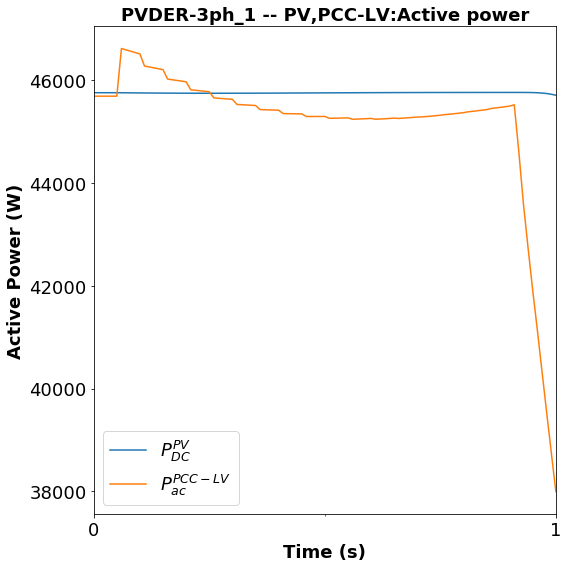

In [8]:
results1.PER_UNIT = False
results1.PLOT_TITLE = True
results1.font_size = 18
results1.plot_DER_simulation(plot_type='active_power_Ppv_Pac_PCC')#

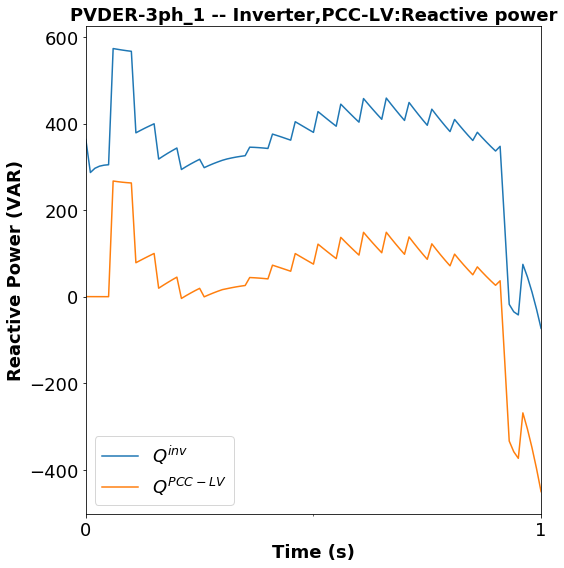

In [9]:
results1.plot_DER_simulation(plot_type='reactive_power')#_Q_PCC

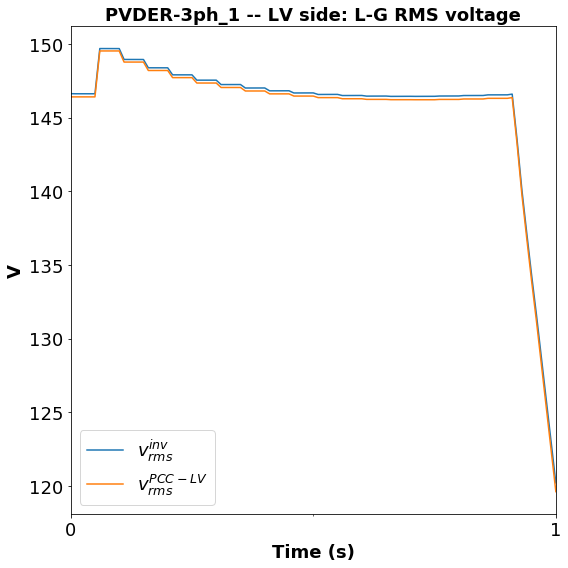

In [10]:
results1.plot_DER_simulation(plot_type='voltage_LV') #voltage_Vpcclv

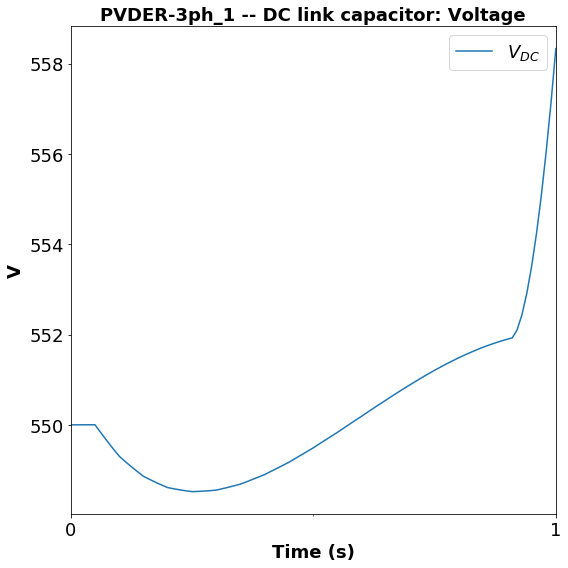

In [11]:
results1.plot_DER_simulation(plot_type='voltage_Vdc')

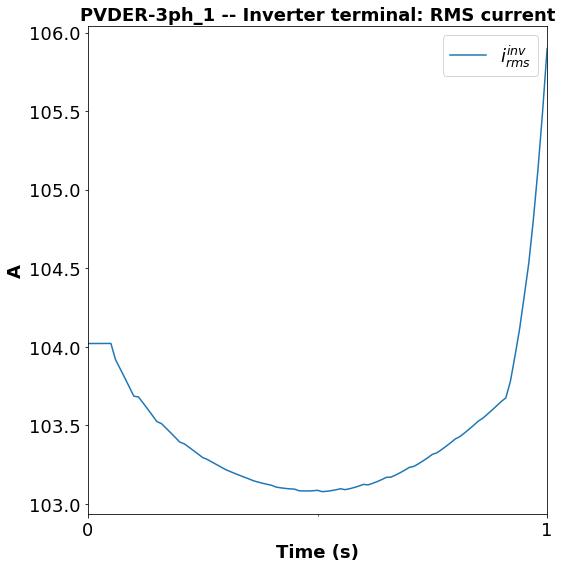

In [12]:
results1.plot_DER_simulation(plot_type='current')

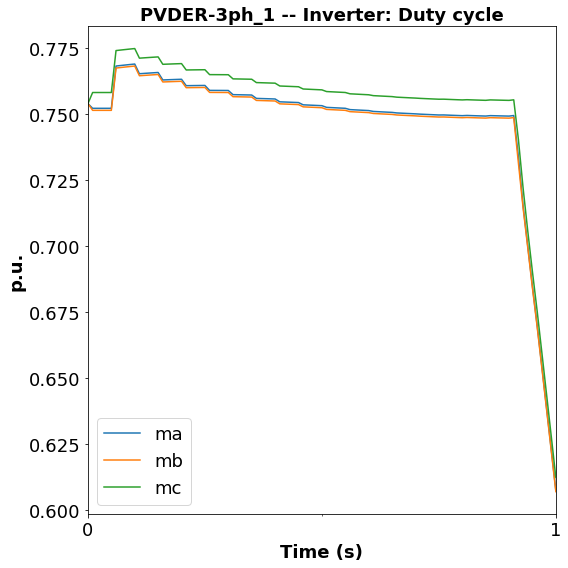

In [13]:
results1.plot_DER_simulation(plot_type='duty_cycle')

### Note that frequency plots don't work in loop mode yet

In [14]:
results1.plot_DER_simulation(plot_type='frequency')

ValueError: Frequency plot is only available if PV-DER model is stand alone!